In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

import matplotlib.pyplot as plt

We implement a Qiskit function `fiveq_ecc` that illustrates the use of the 5-qubit code to correct random Pauli errors. Specifically, this function takes as input a boolean $x \in \mathbb{F}_2$ and an error probability $p$, and outputs a circuit which
- prepares (not fault tolerantly) the logical $|x_L\rangle$ state for the 5-qubit code,
- runs this logical state through a uniform Pauli error channel, with error rate $p$ for each physical qubit,
- measures syndromes for the 5-qubit,
- applies the recovery operations as appropriate, and
- measures the data qubits and decodes the result.

A later part of the notebook will visualize the success probability (as empirically observed from simulations) as a function of $p$. Here the success probabilty is the probabilty that we measure a component of $|x_L\rangle$ at the end. 

The 5-qubit code is a $[[5,1,3]]$ stabilizer code with stabilizers $XZZXI,IXZZX,XIXZZ,ZXIXZ$.
To use the code (for 1-qubit logical states), we need 5 qubits for the codewords, and 4 qubits and 4 classical bits for the syndrome measurements. 

**Logical states** 

The logical codewords for this code are given by
$$ \begin{aligned}
|0_L \rangle = \frac{1}{4} ( & |00000\rangle + |10010\rangle + |01001\rangle + |10100\rangle + |01010\rangle - |11011\rangle - |00110\rangle - |11000\rangle 
\\ - &|11101\rangle - |00011\rangle - |11110\rangle - |01111\rangle - |10001\rangle - |01100\rangle - |10111\rangle + |00101\rangle ), \\
|1_{\rm L} \rangle =\frac{1}{4}( &|11111\rangle + |01101\rangle + |10110\rangle + |01011\rangle + |10101\rangle - |00100\rangle - |11001\rangle - |00111\rangle 
\\- &|00010\rangle - |11100\rangle - |00001\rangle - |10000\rangle - |01110\rangle - |10011\rangle - |01000\rangle + |11010\rangle )
\end{aligned} $$
for the computational basis states. In short: $|0_L \rangle$ is a superposition of all states with an even number of ones; all the amplitudes are equal; the phase is $+1$ if an even number of the pairs $(q_0,q_1), (q_1,q_2), (q_2,q_3), (q_3,q_4), (q_4,q_0)$ are $(1,1)$. $|1_L \rangle = \bar{X} |0_L \rangle$ where $\bar{X} := X^{\otimes 5}$ is the logical $X$ gate for this code.

We can use this to create the following circuit [3] that sends $|0000c\rangle$ to $|c_L \rangle$ for $c \in \{0,1\}$: we first place the four physical qubits in uniform superposition using H gates. Then we use a series of CNOT gates to place the five-qubit state in a uniform superposition of pure states with an even (or odd) number of 1's if $c=0$ (or $c=1$, respectively). We then adjust the phases by applying a series of CZ gates (which can be implemented using Hadamard and CNOT gates). At this point, we have a circuit which sends $|00000 \rangle$ to $|0_L \rangle$ and $|00001 \rangle$ to $-|1_L \rangle$. To remove the last minus sign, we add a Z gate to the last physical qubit before all of the other gates.

**Syndrome decoding**

To decode: we remark that each of the $X,Y,Z$ gates commutes with themselves and the identity, but anticommutes with each of the others (e.g. the $X$ gate commutes with $I$ and $X$ gates and anticommutes with $Z$ gates). Hence an $X$-error in the third physical qubit, for example, should result in a syndrome measurement of $1100$. The complete list of recovery operations for each syndrome measurement is as follows:
| Correction | Syndromes | Correction | Syndromes | Correction | Syndromes |
| -------- | ------- |------- |------- |------- |------- |
| $X_0$ | 0001 | $Y_0$ | 1011 | $Z_0$ | 1010 |
| $X_1$ | 1000 | $Y_1$ | 1101 | $Z_1$ | 0101 |
| $X_2$ | 1100 | $Y_2$ | 1110 | $Z_2$ | 0010 |
| $X_3$ | 0110 | $Y_3$ | 1111 | $Z_3$ | 1001 |
| $X_4$ | 0011 | $Y_4$ | 0111 | $Z_4$ | 0100 |

**References**

[1] Daniel Gottesman, "A Theory of Fault-Tolerant Quantum Computation", Phys.Rev.A57:127,1998. Preprint available at [arXiv:quant-ph/9702029](https://arxiv.org/abs/quant-ph/9702029).

[2] Wikipedia, ["Five-qubit error correcting code"](https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code), accessed 2025/06/30.

[3] Quantum Computing StackExchange, [Question 14264](https://quantumcomputing.stackexchange.com/questions/14264/nielsenchuang-5-qubit-quantum-error-correction-encoding-gate), accessed 2025/06/30.

In [15]:
def fiveq_ecc(x,p):
    reg = QuantumRegister(size=5, name="c")
    anc = AncillaRegister(size=4, name="s")
    syn = ClassicalRegister(size=4, name="syn")
    data = ClassicalRegister(size=5, name="cl") 
    circ = QuantumCircuit(reg,anc,syn,data, name="5-qubit code")

    # prepare state
    # circuit tested separately, this works fine!
    if(x): circ.x(reg[4])
    circ.z(reg[4])
    circ.h(reg[:4])
    #for i in range(4): circ.h(reg[i])
    for i in range(4): circ.cx(reg[i],reg[4])
    for i in range(5): 
        j = (i+1)%5
        circ.h(reg[j])
        circ.cx(reg[i],reg[j])
        circ.h(reg[j])
    circ.barrier()

    # apply uniform Pauli error (for each qubit: no error with probability 1-3p; 
    # x error with probability p, y error with probability p, z with probability p)
    for i in range(2):
        q = np.random.rand()
        if q < p:
            circ.x(reg[i])
        elif q < 2*p:
            circ.y(reg[i])
        elif q < 3*p:
            circ.z(reg[i])
    circ.barrier()

    # extract sydromes
    # XZZXI,IXZZX,XIXZZ,ZXIXZ
    for i in range(4):
        # qiskit uses little-endian convention
        # so first bit in syndrome register is least significant
        # we want *last* syndrome (as listed above) to be stored in least significant bit 
        circ.cx(reg[i], anc[3-i])
        circ.cx(reg[(3+i)%5], anc[3-i])
        circ.h(anc[3-i])
        circ.cx(anc[3-i],reg[(1+i)%5])
        circ.cx(anc[3-i],reg[(2+i)%5])
        circ.h(anc[3-i])
        
    # measure syndromes
    circ.measure(anc, syn)

    # decode (apply corrections)
    with circ.if_test((syn,1)): circ.x(reg[0])
    with circ.if_test((syn,8)): circ.x(reg[1])
    with circ.if_test((syn,12)): circ.x(reg[2])
    with circ.if_test((syn,6)): circ.x(reg[3])
    with circ.if_test((syn,3)): circ.x(reg[4])
    with circ.if_test((syn,10)): circ.z(reg[0])
    with circ.if_test((syn,5)): circ.z(reg[1])
    with circ.if_test((syn,2)): circ.z(reg[2])
    with circ.if_test((syn,9)): circ.z(reg[3])
    with circ.if_test((syn,4)): circ.z(reg[4])
    with circ.if_test((syn,11)): circ.y(reg[0])
    with circ.if_test((syn,13)): circ.y(reg[1])
    with circ.if_test((syn,14)): circ.y(reg[2])
    with circ.if_test((syn,15)): circ.y(reg[3])
    with circ.if_test((syn,7)): circ.y(reg[4])

    # measure data qubits
    circ.measure(reg,data)
    
    return circ

We now run the circuit and visualize the dependence of the success probability on the error probability $p$. Here we define the success probabilty to be the probabilty that we measure a component of $|x_L\rangle$ at the end of the circuit. This is a reasonable definition here since the $|0_L\rangle$ and $|1_L\rangle$ codewords are superpositions of distinct sets of pure states (which together form the computational basis for 5-qubit states).

We will test for error probabilities $p$ in the interval 0 and 0.1; note that the expected number of errors is $3p$ per physical qubit, or $15p$ per logical qubit. For each value of $p$, we will perform 1000 trails using the `AerSimulator`.

In [16]:
def simulate_fiveq_ecc(x,p):
    simulator = AerSimulator()
    rounds = 1000

    # Transpile the circuit for the backend
    compiled_circuit = transpile(fiveq_ecc(x,p), simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=rounds)

    # Get the measurement counts
    counts = job.result().get_counts()
    return counts

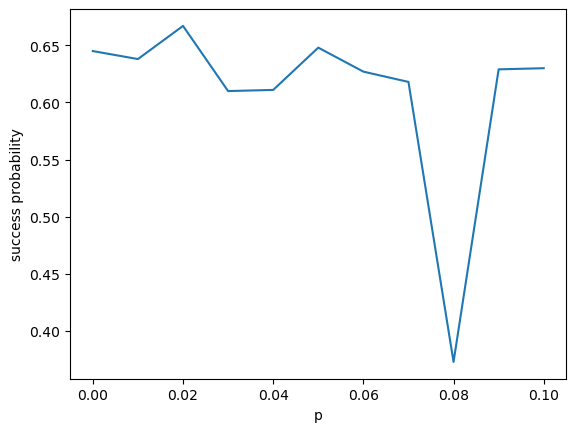

In [17]:
# Visualize
probs, success = [q*0.01 for q in range(11)], []
x = 0
for p in probs:
    counts = simulate_fiveq_ecc(x,p)
    comps = [k for k in counts.keys() if (k[:5].count('1') + x) % 2]
    success += [sum(counts[k] for k in comps) / sum(counts.values())]
plt.plot(probs, success)
plt.xlabel('p')
plt.ylabel('success probability')
plt.show()

The success probability appears to be bounded above by approximately $0.65$, and appears to fall to approximately $0.4$ as we approach $p=0.07$ (where we expect $\sim 1$ errors) [or sometimes earlier!], and then oscilate between about these minimum and maximum values. 